In [1]:
import numpy as np
import scipy.linalg
import pandas as pd
from datetime import datetime
from copy import deepcopy
import matplotlib as mpl

### Zadanie 1
##### Metoda Gaussa-Jordana

Napisz i sprawdź funkcję rozwiązującą układ równań liniowych n × n metodą Gaussa-Jordana z częściowym poszukiwaniem elementu wiodącego. Dla dziesięciu różnych rozmiarów macierzy współczynników większych niż 500 × 500 porównaj czasy działania
zaimplementowanej funkcji z czasami uzyskanymi dla wybranych funkcji bibliotecznych.


In [2]:
def gauss_jordan(A, b):
    A = np.float64(A)
    b = np.float64(b)
    assert A.shape[0] ==  A.shape[0] 
    
    # concat
    Ab = np.concatenate([A, b], axis=1)

    # scaling
    Ab = Ab/np.max(Ab, axis=1).reshape(-1,1)
    
    h, k = 0, 0
    while k<Ab.shape[1]-1:
        p = np.argmax(np.absolute(Ab[h:,k])) + h
        if Ab[p, k] != 0:
            # swapping rows
            Ab[[h, p], :] = Ab[[p, h],:]
            
            # get factor
            f = Ab[:,k] / Ab[h,k]
            f = f.reshape(-1, 1)
            
            # subtract pivot row from lower rows
            Ab[h+1:,:] -= Ab[h,:]*f[h+1:]

            # subtract pivot row from upper rows
            Ab[:h,:] -= Ab[h,:]*f[:h]
            
            # scale pivot row
            Ab[h,:] /= Ab[h,k]
    
            h+=1        
        k+=1
        
    return Ab[:,Ab.shape[1]-1].reshape(-1,1)

##### Czy w ogóle działa? Najwyraźniej tak.

In [3]:
n = 3
A  = np.random.uniform(-10, 10, (n, n))
b = np.random.uniform(-10, 10, (n, 1))
A, b

(array([[-5.88711519, -2.9756557 ,  7.91755195],
        [ 4.41912312, -1.23672748, -6.47816719],
        [-8.52333349, -4.24771457,  0.77077037]]),
 array([[7.35255718],
        [5.36628318],
        [7.93252067]]))

In [4]:
x = gauss_jordan(A, b)
assert np.linalg.norm(A@x - b)<1e-14

#### Porównanie z bibliotecznymi funkcjami

In [5]:
norms = {'my_own':[], 'numpy':[], 'scipy':[]}
n = 100

In [6]:
%%timeit
A  = np.random.uniform(-1000, 1000, (n, n))
b = np.random.uniform(-1000, 1000, (n, 1))
x = gauss_jordan(A, b)

7.72 ms ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%%timeit
A  = np.random.uniform(-1000, 1000, (n, n))
b = np.random.uniform(-1000, 1000, (n, 1))
x= np.linalg.solve(A, b)

2.14 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
A  = np.random.uniform(-1000, 1000, (n, n))
b = np.random.uniform(-1000, 1000, (n, 1))
x = scipy.linalg.solve(A, b)

1.9 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Wygląda na to, że np.linalg.solve działa najszybciej, ale scipy.linalg.solve niewiele wolniej. <br>Moja implementacja dla podanego rozmiaru macierzy działa około 2 razy wolniej

In [9]:
Ns = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]

for n in Ns:
    A  = np.random.uniform(-1000, 1000, (n, n))
    b = np.random.uniform(-1000, 1000, (n, 1))
    
    start_time = datetime.now()
    x = np.linalg.solve(A, b)
    end_time = datetime.now()
    execution_time_2 = round((end_time - start_time).total_seconds() * 1000)
    
    start_time = datetime.now()
    x = gauss_jordan(A, b)
    end_time = datetime.now()
    execution_time_1 = round((end_time - start_time).total_seconds() * 1000)

    
    print(f"Macierz {n}x{n}")
    print(f"Moja: {execution_time_1}ms, numpy {execution_time_2}ms")
    print()

Macierz 500x500
Moja: 348ms, numpy 70ms

Macierz 600x600
Moja: 641ms, numpy 31ms

Macierz 700x700
Moja: 1050ms, numpy 53ms

Macierz 800x800
Moja: 1685ms, numpy 60ms

Macierz 900x900
Moja: 2274ms, numpy 32ms

Macierz 1000x1000
Moja: 3134ms, numpy 36ms

Macierz 1100x1100
Moja: 4483ms, numpy 63ms

Macierz 1200x1200
Moja: 5897ms, numpy 66ms

Macierz 1300x1300
Moja: 7285ms, numpy 52ms

Macierz 1400x1400
Moja: 8885ms, numpy 61ms

Macierz 1500x1500
Moja: 10839ms, numpy 58ms



Podczas gdy obie funkcje miały podobny czas wykonania dla mniejszego rozmiaru macierzy, moja implementacja słabo radzi sobie z większymi macierzami. Funkcja numpy.linalg.solve działa znacznie szybciej. 

### Zadanie 2
##### Faktoryzacja LU

Napisz i przetestuj funkcję dokonującą faktoryzacji A = LU macierzy A (bez poszukiwania elementu wiodącego). Sprawdź poprawność wyniku obliczając |A − LU|. Zadbaj o to żeby implementacja była in-situ. Elementy macierzy L to współczynniki mnożenia umożliwiające wyzerowanie odpowiedniego współczynnika macierzy A w trakcie procesu
eliminacji.

In [10]:
def LU(A):
    for i in range(A.shape[1]):
        # get factor
        f = A[i+1:,i]/A[i,i]
        
        # subtract from lower rows
        A[i+1:,i:] -= A[i,i:]*f.reshape(-1, 1)
        
        # save factors below diagonal
        A[i+1:,i] = f
        
    return np.tril(A, -1) + np.eye(A.shape[0]), np.triu(A)


In [11]:
n = 50
A = np.random.uniform(-1000, 1000, (n, n))

In [12]:
L, U = LU(deepcopy(A))
assert np.linalg.norm(A-L@U)<1e-8

### Zadanie 3
##### Analiza obwodu elektrycznego - nadokreślony układ równań

In [13]:
import zad3
import networkx as nx
mpl.rcParams['figure.figsize'] = [16, 8]

In [14]:
s, t, E = 1, 2, 100
G = zad3.generate_random_graph(20, s, t)
m = len(G.edges)

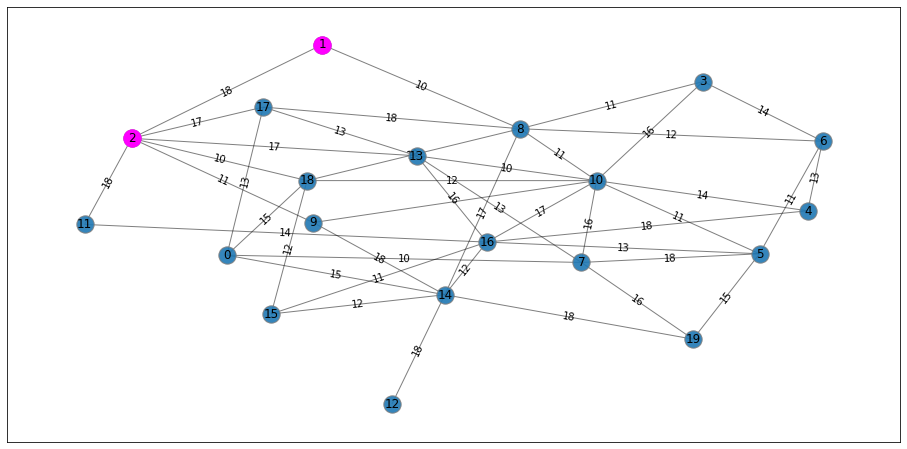

In [15]:
zad3.draw_resistance(G, s, t)

In [16]:
A = np.concatenate([
        zad3.get_eq_path(G, s, t),
        zad3.get_eqs_kirchhoff_1(G, s, t),
        zad3.get_eqs_kirchhoff_2(G)
        ])

b = np.zeros(len(A))
b[0] = E

G_flow = zad3.get_flow_graph(G, A, b)

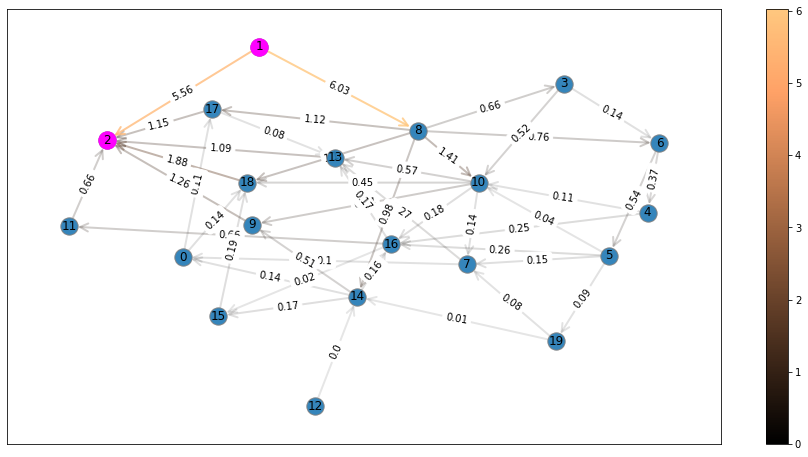

In [17]:
zad3.draw_flow(G, G_flow, s, t)

*Graf ma **n** wierzchołków, **m** krawędzi, jest spójny.*

Używając I prawa Kirchhoffa uzyskuję **n-2** równań (dla każdego węzła oprócz **s** i **t**).
Używając II prawa Kirchoffa powinienem uzyskać **m-n+1** równań (jedno dla każdego cyklu prostego, których w spójnym nieskierowanym powinno być właśnie tyle). Jedno równanie uzyskuję ze znanej różnicy potencjałów między **s** i **t**, sumując spadki napięć na ścieżce między tymi wierzchołkami.

W sumie uzyskuję **m** równań. Macierz współczynników jest kwadratowa, a układ nie jest nadokreślony. Do znalezienia cykli prostych używam funkcji z biblioteki networkx, ale nietrudno byłoby napisać własną funkcję.
